# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statistics
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [4]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [5]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [ ]:
#Filter through zip codes to find the top 5 highest positive percent change
def top_5_filter(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    aggregation = {
        'value': {
            'Initial Value': 'first',
            'Final Value': 'last',
        }
    }
    df2 = melted.groupby(['RegionName']).aggregate(aggregation)
    df2.columns = df2.columns.droplevel(level=0)
    df2['Percent Change'] = (((df2['Initial Value']-df2['Final Value'])/df2['Initial Value'])*100)
    return df2.sort_values(by = 'Percent Change', ascending = False).head(5)

# Step 3: Reshape from Wide to Long Format

In [241]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.RegionName = melted.RegionName.apply(str)
    return melted

In [7]:
# def melt_data_ts(df):
#     melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

In [8]:
# time_series = melt_data_ts(df)

In [242]:
melted_df = melt_data(df)

In [243]:
melted_df.head(20)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [244]:
melted_df.drop(['RegionID','City','State','Metro','CountyName','SizeRank'],inplace = True, axis = 1)

In [245]:
melted_df.value.isnull().sum()

0

In [246]:
stacked_df = melted_df.set_index('time','RegionName')

In [247]:
stacked_df.value.isnull().sum()

0

In [248]:
zipcodedf = stacked_df.unstack()


In [250]:
stacked_df.head()

,RegionName,value
time,,
1996-04-01,60657,334200.0
1996-04-01,75070,235700.0
1996-04-01,77494,210400.0
1996-04-01,60614,498100.0
1996-04-01,79936,77300.0


In [216]:
zipcode_df = zipcodedf.T
zipcode_df.index = zipcode_df.index.droplevel(level = 0)

In [217]:
zipcode_df.head()

RegionName,1001,1002,1005,1007,1008,1010,1011,1013,1020,1026,...,99654,99664,99669,99701,99705,99709,99712,99801,99835,99901
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,113100.0,161000.0,103100.0,133400.0,117500.0,115800.0,87000.0,88500.0,97200.0,91200.0,...,122700.0,112200.0,112500.0,89400.0,101900.0,103000.0,109200.0,166800.0,155500.0,117100.0
1996-05-01,112800.0,160100.0,103400.0,132700.0,117300.0,115700.0,87000.0,88500.0,97100.0,91100.0,...,124200.0,112400.0,113100.0,89800.0,102900.0,103900.0,109600.0,166200.0,154900.0,117200.0
1996-06-01,112600.0,159300.0,103600.0,132000.0,117100.0,115500.0,87100.0,88400.0,97000.0,91000.0,...,125700.0,112600.0,113800.0,90200.0,103800.0,104700.0,110000.0,165400.0,154200.0,117300.0
1996-07-01,112300.0,158600.0,103800.0,131400.0,117000.0,115300.0,87200.0,88300.0,96800.0,90800.0,...,127200.0,112800.0,114400.0,90600.0,104700.0,105500.0,110400.0,164400.0,153500.0,117400.0
1996-08-01,112100.0,158000.0,103900.0,130800.0,116800.0,115100.0,87400.0,88200.0,96600.0,90700.0,...,128600.0,113000.0,115100.0,91000.0,105400.0,106200.0,110800.0,163500.0,152800.0,117500.0


In [251]:
# zipcode_df['22937']

In [218]:
zips = [22937,17236,17252,49713,31520]
zipcode_top5 = pd.DataFrame(zipcode_df[zips])

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

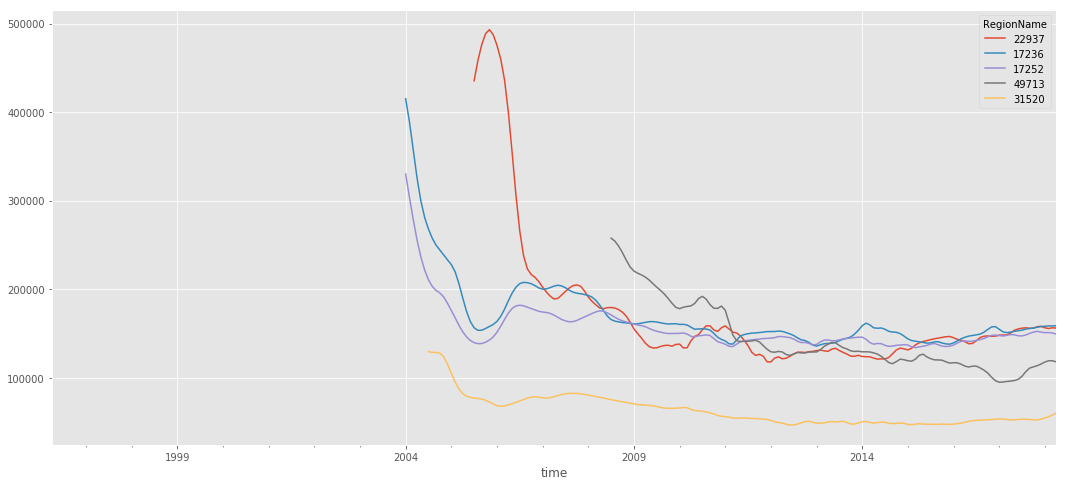

In [233]:
#inital series look
zipcode_df[zips].plot(figsize = (18,8))
plt.show()

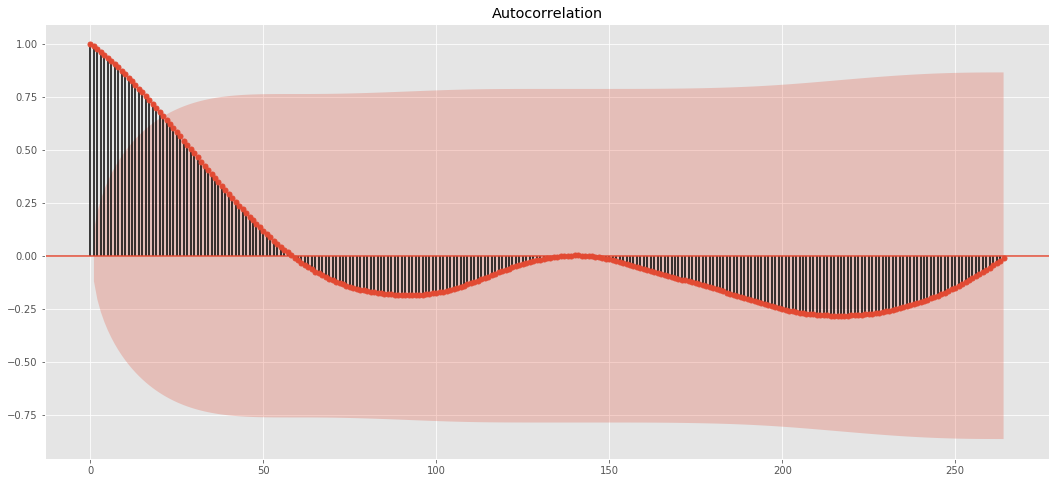

In [12]:
#from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plot_acf(time_series, alpha =.05)
plt.show()

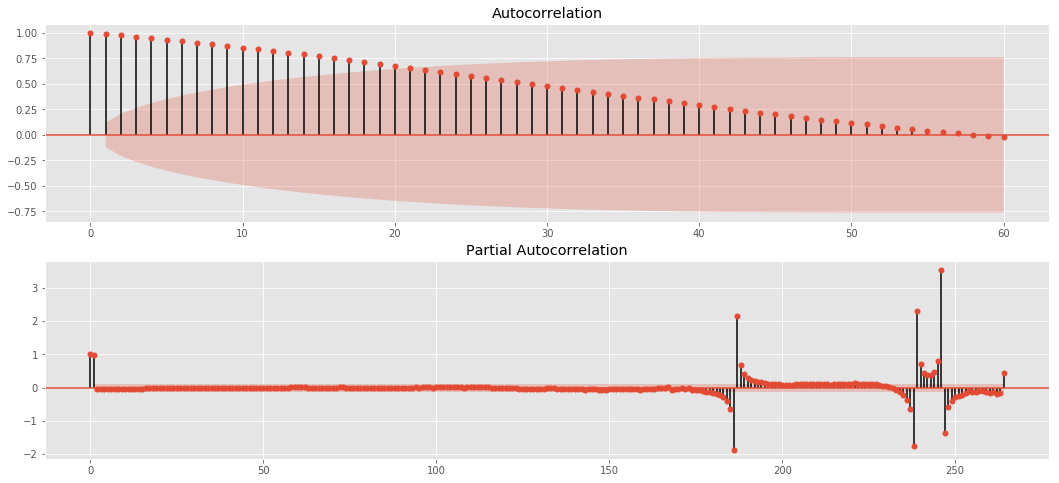

In [13]:
fig = plt.figure(figsize = (18,8))
ax1 = fig.add_subplot(211)
plot_acf(time_series, lags = 60, alpha =.05, ax = ax1)
ax2 = fig.add_subplot(212)
plot_pacf(time_series,alpha = .05, ax = ax2)
plt.show()

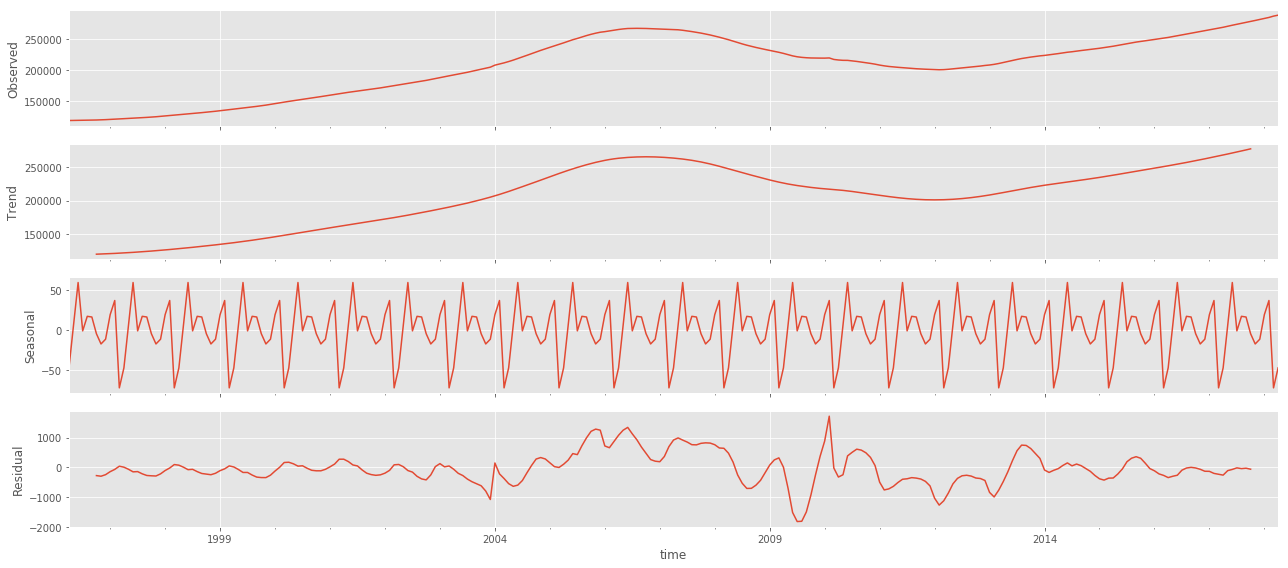

In [14]:
#show the trend of the data, the seasonality, and the noise
decomposition = sm.tsa.seasonal_decompose(time_series, model='additive')
fig = decomposition.plot()
plt.show()

In [15]:
#dickey fuller test to check for stationarity
dftest = adfuller(time_series['value'])
print(dftest)

(-1.885144518377796, 0.33908154394125245, 2, 262, {'1%': -3.455558114028747, '5%': -2.872635586277424, '10%': -2.572682677000175}, 3505.613476823798)


because p > .05, we fail to reject the Ho.  Our data is non-stationary

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

Due to the seasonality of the data we will be using SARIMA
we will use a grid search technique to find the best model for our data

In [16]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


# Grid Search

In [17]:
min_aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_series, order=param, 
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
            results = mod.fit()
            min_aic.append([param, param_seasonal, results.aic])
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7227.7079129085505
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6742.951906588516
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:10813.716747898401
ARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:8270.148417360637
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5572.264748163526
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5318.059513535702
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:4800.494711138364
ARIMA(0, 0, 0)x(0, 1, 3, 12)12 - AIC:5342.469961020498
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:5034.520292642388
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:4774.3387988216455
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:4501.533934803198
ARIMA(0, 0, 0)x(0, 2, 3, 12)12 - AIC:4255.93780501604
ARIMA(0, 0, 0)x(0, 3, 0, 12)12 - AIC:31841.87097326095
ARIMA(0, 0, 0)x(0, 3, 1, 12)12 - AIC:14366.50814345418
ARIMA(0, 0, 0)x(0, 3, 2, 12)12 - AIC:6941.121174071093
ARIMA(0, 0, 0)x(0, 3, 3, 12)12 - AIC:6104.810673633053
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5540.959630400202
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5491.481015464051
ARIMA(0,

we turn off enforce_stationarity and invertibility because it is not needed if we have the correct params

In [20]:
aic_df = pd.DataFrame(min_aic, columns=['pdq', 'pdqs', 'aic'])
aic_df.loc[aic_df['aic'].idxmin()]

pdq         (0, 2, 3)
pdqs    (3, 3, 3, 12)
aic           2908.12
Name: 767, dtype: object

In [21]:
SARIMA_model = SARIMAX(time_series,order = (0,2,3), seasonal_order = (3,3,3,12), enforce_stationarity = False, enforce_invertibility = False)
results = SARIMA_model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(0, 2, 3)x(3, 3, 3, 12)   Log Likelihood               -1444.059
Date:                            Fri, 26 Jul 2019   AIC                           2908.118
Time:                                    18:30:01   BIC                           2940.429
Sample:                                04-01-1996   HQIC                          2921.210
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2385      0.031     -7.654      0.000      -0.300      -0.177
ma.L2         -0.0075      0.042   

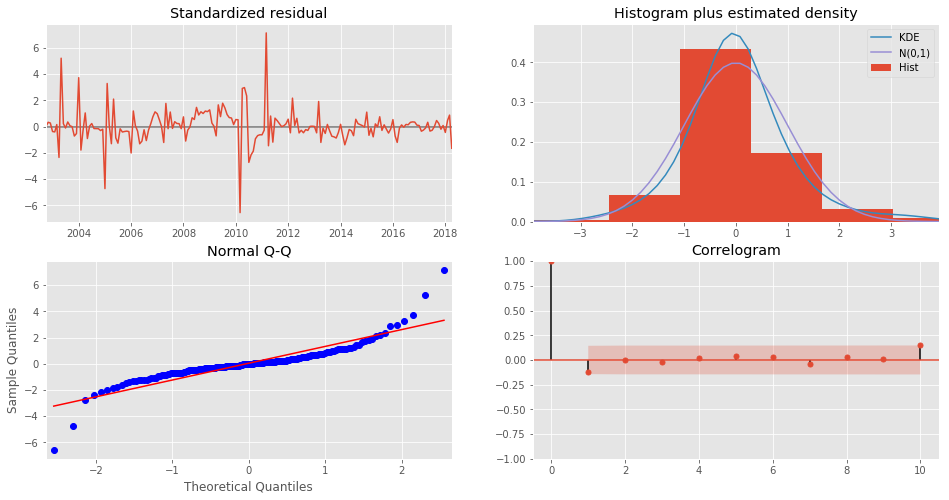

In [22]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

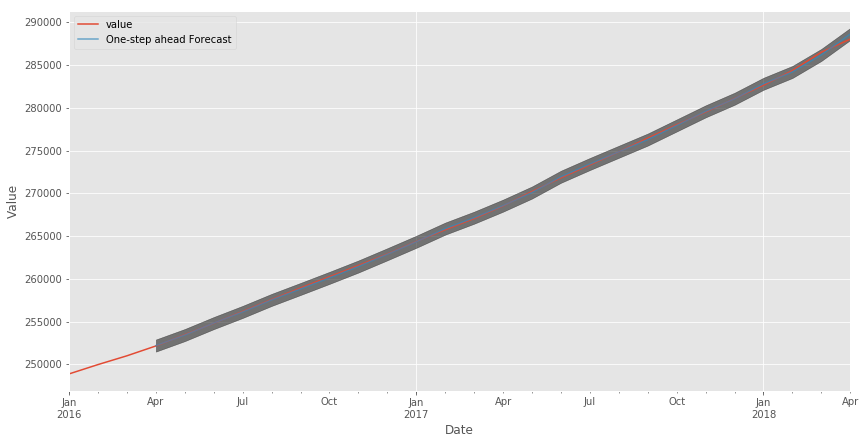

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_ci = pred.conf_int()
#observed values
ax = time_series['2016':].plot(label='observed')
#pred values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#range of CI
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [41]:
y_forecasted = pred.predicted_mean
y_truth = time_series['2016-04-01':]['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27141.37


In [42]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 164.75


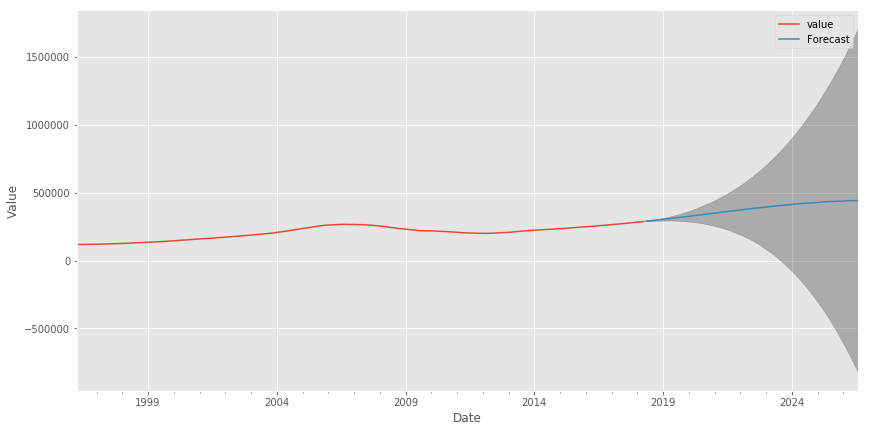

In [48]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = time_series.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.